(linreg_pymc)=
# Linear regression (PyMC)

## Introduction to ordinary linear regression

Linear regression models are usually the first example shown in most statistical learning lectures. They are a popular introduction to statistical modelling because of their simplicity, while their structure is flexible and applicable to quite a large range of physical systems.

In the words of {cite:p}`gelman2013bayesian` : "in the normal linear model framework, the first key statistical modelling issue is defining the variables $x$ and $y$, possibly using transformations, so that the conditional expectation of $y$ is reasonably linear as a function of the columns of $X$ with approximately normal errors." The second main issue, related to a Bayesian analysis framework, is a proper specification of the prior distribution on the model parameters.

We consider an output variable $y$, and a set of explanatory variables $x=(x_1,...,x_k)$, and assume that a series of $n$ values of $y_i$ and $x_{i1},...x_{ik}$ have been recorded. The *ordinary* linear regression model states that the distribution of each $y_i$ given the $n\times k$ matrix of predictors $X$ is normal with a mean that is a linear function of $X$:

```{math}
:label: linreg1:
y_i = \alpha + \beta_1 x_{i1} + ... + \beta_k x_{ik} + \varepsilon
```

with $\varepsilon \sim N(0, \sigma)$. This is equivalent to writing:

```{math}
:label: linreg2:
y_i \sim \mathcal{N} \left( \alpha + \beta_1 x_{i1} + ... + \beta_k x_{ik} , \sigma \right)
```

We are therefore looking for an array of parameters $\theta = (\alpha, \beta_1, ..., \beta_k, \sigma)$.

Ordinary linear regression assumes a normal linear model in which observation errors are independent and have equal variance $\sigma^2$. Under these assumptions, along with a uniform prior distribution on $\alpha$ and $\beta$, the posterior distribution for $\theta$ conditional on $\sigma$ has an explicit solution {cite:p}`james2013introduction`.

The ordinary linear regression model is enough to explain the variability of the data if the regression errors $y_i - E(y_i|\theta, X)$ are independent, identically distributed with constant variance $\sigma^2$. If that is not the case, the model can be extended into a generalized linear model.

* The expected value $E(y_i|\theta, X)$ may be non-linear or include non-linear transformations of the explanatory variables.
* Unequal variances and correlated errors can be included by allowing a	data covariance matrix $\Sigma_y$ that is not necessarily proportional to the identity matrix: $y \sim N(X\theta, \Sigma_y)$.
* A non-normal probability distribution can be used.

## Linear regression with PyMC

This tutorial will serve as an introduction to [PyMC](https://www.pymc.io/welcome.html). It is not a complete course on how this library works, but links to the relevant parts of the PyMC documentation will be provided. We also cover some basics of the [ArviZ](https://python.arviz.org/en/stable/) library.

### Data

The data are two years of monthly energy consumption of a school, along with two independent variables: heating degree days (HDD) and number of class days. The data file can be downloaded [here](https://github.com/srouchier/buildingenergygeeks/blob/master/data/linreg.csv).

The first half of the data is labeled `pre` and will be used for training. The second half is labeled `post` and will be used for validating model forecasts.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import arviz as az
import pymc as pm

df = pd.read_csv('data/linreg.csv')
df.head()

/home/simon/anaconda3/envs/bayes_env/lib/python3.11/site-packages/arviz/data/base.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


,observation,consumption,HDD,CLASSDAYS,period
0,1,321120,12.7,0.0,pre
1,2,335520,19.4,6.0,pre
2,3,412560,147.6,20.0,pre
3,4,394560,353.4,20.0,pre
4,5,424080,526.7,20.0,pre


Let's start by taking a look at the data. The 'pre' and 'post' labels denote periods before and after an energy conservation measure was taken, because this is an M&V example dataset. For now we will only use the 'pre' data.

Text(0.5, 0, 'classdays')

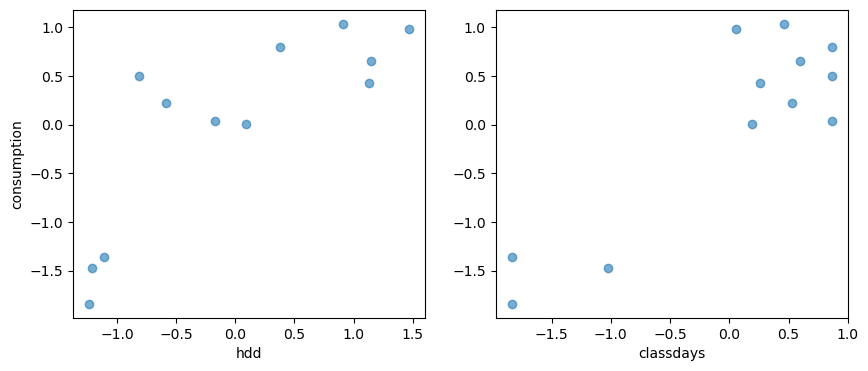

In [2]:
# Separating pre and post periods
df_train = df[df['period']=="pre"]
df_test = df[df['period']=="post"]

# Inputs and outputs, normalized
X1 = (df_train['HDD'] - df_train['HDD'].mean()) / df_train['HDD'].std()
X2 = (df_train['CLASSDAYS'] - df_train['CLASSDAYS'].mean()) / df_train['CLASSDAYS'].std()
Y = (df_train['consumption'] - df_train['consumption'].mean()) / df_train['consumption'].std()

# A plot of the dependent variable vs. each of the explanatory variables
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("consumption")
axes[0].set_xlabel("hdd")
axes[1].set_xlabel("classdays")

### Model specification

As a first step, we will attempt to predict the energy consumption $y$ by a linear function of HDD $x_1$ only

$$
y = \alpha + \beta_1 x_1 + \varepsilon
$$ (linregmodel1a)

with $\varepsilon \sim N(0, \sigma)$. This is equivalent to writing:

$$
y \sim \mathcal{N} \left( \alpha + \beta_1 x_1 \; , \sigma \right)
$$ (linregmodel1b)

We are therefore looking for three parameters $(\alpha, \beta_1, \sigma)$. Later in this tutorial, we will train a model taking the number of class days as a second input variable, for comparison.

The methodology below follows [PyMC's introductory overview](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html) which explains the library's syntax. A PyMC model is defined within a context manager where its probability statements are made:

In [3]:
model1 = pm.Model()

with model1:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=1, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu= alpha + beta * X1, sigma=sigma, observed=Y)


The first three lines define prior distributions for the three parameters of the model. The intercept $\alpha$ and slope $\beta_1$ have normal distributions centered around 0 and 1, respectively, because the data have been normalized. The uncertainty $\sigma$ has a half normal distribution, so that its value is constrained to be positive.

The last line of the model is Eq. {eq}`linregmodel1b`: the observed variable $y$, stored in the array `Y`, follows a normal distribution with mean $\alpha + \beta x$ and standard deviation $\sigma$.

### Prior predictive sampling

The first three lines of the model above define prior distributions for each of the three parameters $(\alpha, \beta, \sigma)$. This step is optional but highly recommended in any Bayesian workflow.

Before we proceed further, we can see look at the model's output if it only draws from these priors. This step is called prior predictive sampling, and allows checking if the model is consistent. Prior predictive checks help you check how credible your assumptions before seeing the data are.

In [4]:
with model1:
    priordata_1 = pm.sample_prior_predictive(1000)

Sampling: [Y_obs, alpha, beta, sigma]


`priordata_1` is an [InferenceData object from the ArviZ library](https://python.arviz.org/en/stable/getting_started/WorkingWithInferenceData.html). It is a multidimensional xarray that you can visualize and explore by displaying it in Jupyter:

In [5]:
priordata_1

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

* The `priordata_1.prior` dataset stores the 1000 draws from the prior distribution that we asked.
* The `priordata_1.prior_predictive` dataset stores all 12 predictions of `Y_obs` from each of these 1000 draws. The following figure compares this predictive distribution with the data.

Text(0, 0.5, 'consumption')

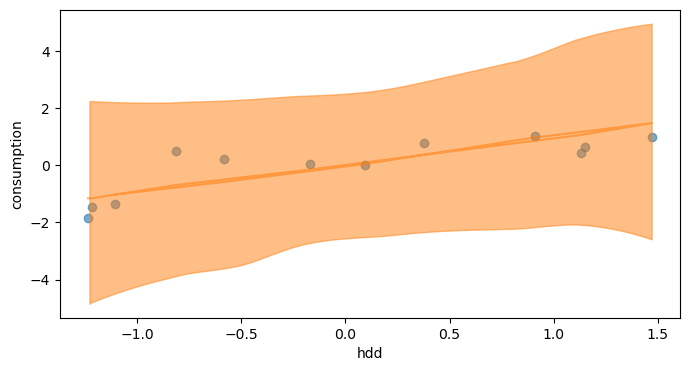

In [6]:
# The same plot as before but with the predictions drawn from the prior
yprior = priordata_1.prior_predictive['Y_obs']

fig, axes = plt.subplots(figsize=(8, 4))

axes.scatter(X1, Y, alpha=0.6)
#axes[0].plot(X1, yprior.stack(sample=("chain", "draw")), c="k", alpha=0.2)
axes.plot(X1, yprior.mean(("chain", "draw")), c="C1", alpha=0.6)
az.plot_hdi(X1, yprior)
axes.set_xlabel("hdd")
axes.set_ylabel("consumption")

The orange area shows the Highest Density Interval of the prior predictive distribution, which is the minimum width [Credible Interval](https://en.wikipedia.org/wiki/Credible_interval) of a certain probability. Ideally, most of the data should be comprised in it for the initial model to be consistent. This is the case here, because our choice of priors was quite conservative.

### Model training

In Bayesian terms, model "training" is called **conditioning** the model on the data. This is done by calling the `sample()` method within the context manager:

In [7]:
with model1:
    trace_1 = pm.sample(chains=4, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
/home/simon/anaconda3/envs/bayes_env/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


The sample function runs the step method(s) assigned (or passed) to it for the given number of iterations and returns an InferenceData object containing the samples collected, along with other useful attributes like statistics of the sampling run and a copy of the observed data. Notice that sample generated a set of parallel chains, depending on how many compute cores are on your machine. It is recommended to use 4 chains, unless you are just doing some explanatory analysis and are trying to save time.

The argument `idata_kwargs={"log_likelihood": True}` ensures that the log likelihood of each draw and observation is saved. This is required to perform model comparison later.

Like the prior data, `trace_1` is an `InferenceData` object containing the samples collected, along with other useful attributes like statistics of the sampling run and a copy of the observed data.

In [8]:
trace_1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

For example, here is how to access the posterior distribution of the $\alpha$ parameter specifically:

In [9]:
trace_1.posterior["alpha"]

<xarray.DataArray 'alpha' (chain: 4, draw: 1000)> Size: 32kB
array([[ 0.01544521, -0.11232055, -0.10913377, ..., -0.23639128,
        -0.44262497, -0.06422109],
       [ 0.33588222, -0.15927737,  0.09134005, ...,  0.12522283,
         0.11231244,  0.00831521],
       [ 0.00485296, -0.2261003 ,  0.01750406, ...,  0.01377853,
         0.20036391, -0.01844035],
       [ 0.06165868,  0.43291975, -0.11726025, ..., -0.0174421 ,
         0.08452896,  0.08452896]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

After training, we should immediately check for the proper convergence of the MCMC algorithm, before any interpretation of results.

The ArviZ library includes diagnostics functionalities. A simple posterior plot can be made using `plot_trace`:

/home/simon/anaconda3/envs/bayes_env/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

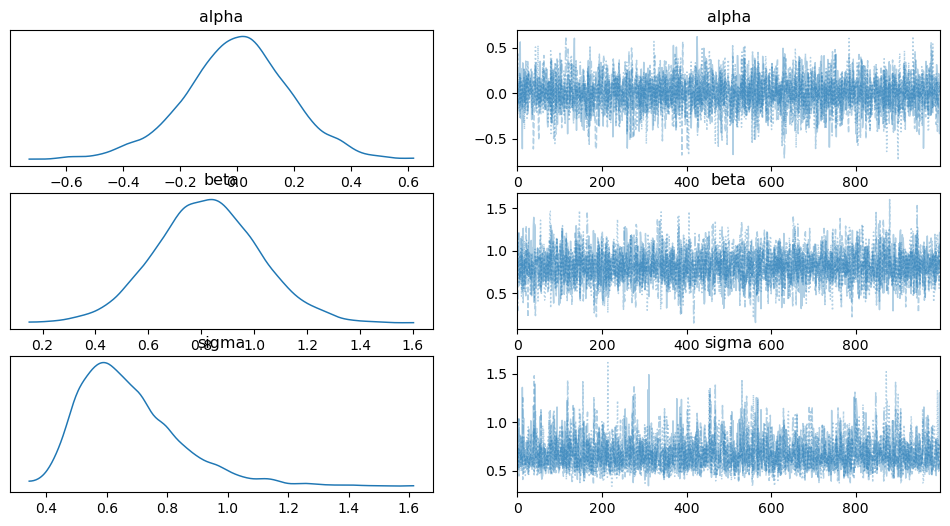

In [10]:
az.plot_trace(trace_1, combined=True)

In addition, the summary function provides a text-based output of common posterior statistics.

In [11]:
az.summary(trace_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.002,0.190,-0.370,0.364,0.003,0.003,3890.0,2968.0,1.0
beta,0.822,0.197,0.464,1.212,0.003,0.002,3516.0,2542.0,1.0
sigma,0.673,0.168,0.420,0.997,0.003,0.002,2626.0,2859.0,1.0


The two diagnostics metrics mentioned in {ref}`workflow_step2` are satisfactory:
* The effective sample size (ESS) is high enough (in the thousands);
* The $\hat{R}$ statistic should be close to exactly 1.

This does not ensure that our model is the best fit, or even "good", only that the algorithm has converged.

### Posterior predictive distribution

PyMC has a dedicated function to sample from the posterior predictive distribution: its syntax is similar to the prior sampling we already showed.

The `extend_inferencedata=True` option allows saving posterior_prediction within the existing `trace_1` object. Without this option, the method returns the draws in a separate object.

The following block adds a `posterior_predictive` dataset within the `trace_1` object and displays it.

In [12]:
with model1:
    pm.sample_posterior_predictive(trace_1, extend_inferencedata=True)

trace_1.posterior_predictive

Sampling: [Y_obs]


Output()

<xarray.Dataset> Size: 392kB
Dimensions:      (chain: 4, draw: 1000, Y_obs_dim_2: 12)
Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * Y_obs_dim_2  (Y_obs_dim_2) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    Y_obs        (chain, draw, Y_obs_dim_2) float64 384kB -1.084 ... -1.027
Attributes:
    created_at:                 2025-09-23T06:55:08.787881
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  5.10.4

A posterior predictive plot takes multiple samples from the posterior (intercepts and slopes) and plots a regression line for each of them. We can manually generate these regression lines using the posterior samples directly.

Alternatively, we can also display the posterior predictive credible intervals like we did after prior sampling:

Text(0, 0.5, 'consumption')

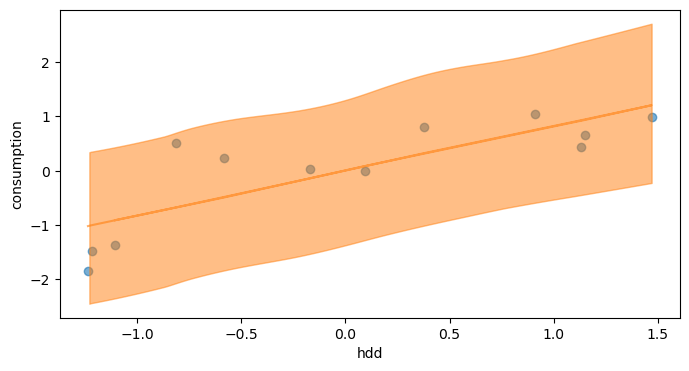

In [13]:
y_post = trace_1.posterior_predictive["Y_obs"]

fig, axes = plt.subplots(figsize=(8, 4))

axes.scatter(X1, Y, alpha=0.6)
axes.plot(X1, y_post.mean(("chain", "draw")), c="C1", alpha=0.6)
az.plot_hdi(X1, y_post)
axes.set_xlabel("hdd")
axes.set_ylabel("consumption")

The prediction intervals have been significantly narrowed between prior and posterior predictions. The uncertainty is however still quite high.

## Model comparison

Let's see if the model is improved by adding class days as a second explanatory variable $x_2$:

$$
y = \alpha + \beta_1 x_1 + \beta_2 x_2 + \varepsilon
$$ (linregmodel2)

We define `model2` in a PyMC block that already includes the functions for prior sampling, training and posterior sampling:

In [14]:
model2 = pm.Model()

with model2:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=[1, 1], sigma=[1, 1], shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    # Sampling from the prior predictive distribution
    priordata_2 = pm.sample_prior_predictive(1000)

    # Training
    trace_2 = pm.sample(chains=4, idata_kwargs={"log_likelihood": True})

    # Posterior
    pm.sample_posterior_predictive(trace_2, extend_inferencedata=True)

Sampling: [Y_obs, alpha, beta, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
Sampling: [Y_obs]


Output()

Let us quickly check for MCMC convergence before we proceed any further.

In [15]:
az.summary(trace_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.001,0.101,-0.188,0.192,0.002,0.002,3105.0,2138.0,1.0
beta[0],0.468,0.135,0.218,0.723,0.003,0.002,2335.0,1872.0,1.0
beta[1],0.620,0.131,0.374,0.864,0.003,0.002,2585.0,1895.0,1.0
sigma,0.350,0.098,0.200,0.528,0.002,0.002,1754.0,1994.0,1.0


We just trained two models on the same dataset. We will now compare them on the basis of their *expected* prediction performance: the ELPD.

ArviZ has a built-in function to compare several models based on their traces. The default criterion for model comparison is the ELPD calculated by leave-one-out (LOO) cross validation.

In [16]:
df_comp_loo = az.compare({"model1": trace_1, "model2": trace_2}, ic="loo")
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model2,0,-5.538327,3.070049,0.000000,1.0,1.18444,0.000000,False,log
model1,1,-13.119232,2.368397,7.580904,0.0,2.19182,2.235794,False,log


This table ranks models from best to worst according to the LOO criterion. [This page from PyMC's documentation](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html) describes the content of each column. The most relevant to us are:

* `rank`, the ranking of the models starting from 0 (best model)
* `elpd_loo`, the values of LOO (or WAIC). The DataFrame is always sorted from best LOO/WAIC to worst.
* `se`, the standard error for the LOO/WAIC computations. The standard error can be useful to assess the uncertainty of the LOO/WAIC estimates. By default these errors are computed using stacking.
* `warning`, if True the computation of LOO/WAIC may not be reliable.

We could also have specified `ic="waic"`, which would have compared models based on the WAIC criterion.

According to these results, the best choice for prediction is the second model, with two explanatory variables hdd and school days.

Text(0.5, 0, 'class days')

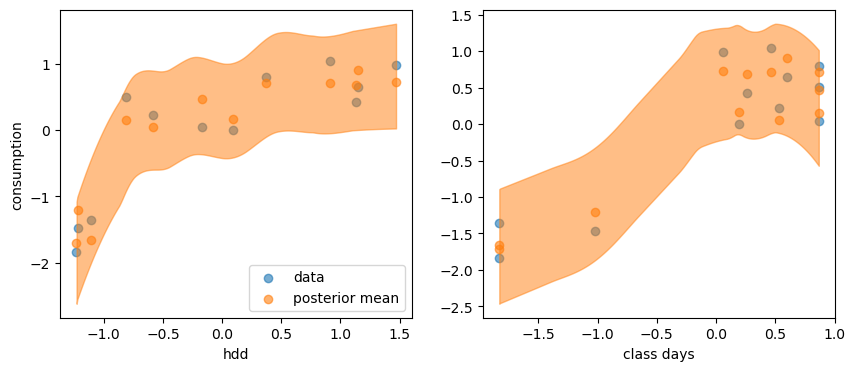

In [17]:
y_post = trace_2.posterior_predictive["Y_obs"]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(X1, Y, alpha=0.6, label='data')
axes[0].scatter(X1, y_post.mean(("chain", "draw")), c="C1", alpha=0.6, label='posterior mean')
az.plot_hdi(X1, y_post, ax=axes[0])
axes[0].set_xlabel("hdd")
axes[0].set_ylabel("consumption")
axes[0].legend()

axes[1].scatter(X2, Y, alpha=0.6)
axes[1].scatter(X2, y_post.mean(("chain", "draw")), c="C1", alpha=0.6)
az.plot_hdi(X2, y_post, ax=axes[1])
axes[1].set_xlabel("class days")